In [22]:
#01_model_training_and_tuning.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer

#Load dataset

dataset2=pd.read_csv("C:/sat_cohort/final/SAT_Cohort_XAI_model2_QoL_bi_expActlong.csv", header=0)
dataset2.tail()
X = dataset2.loc[:,'age':'diffI_Reflecting']
y = dataset2.loc[:,'geh_less33_0']


#Split into train/test

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.20, random_state=7)

#GridSearchCV was applied to tune only 'learning_rate' and 'n_estimators'.

xgb_params = {
'booster': 'gbtree',
'objective': 'binary:logistic',
'learning_rate': 0.06,        # tuned by GridSearchCV
'n_estimators': 50,           # tuned by GridSearchCV
'max_depth': 3,               # fixed for regularization
'subsample': 0.89,             # fixed
'min_child_weight': 2,        # fixed
'gamma': 0.5,                 # fixed
'use_label_encoder': False,
'eval_metric': 'logloss'
}

#Train final model with optimal parameters

model2 = XGBClassifier(**xgb_params)
model2.fit(X_train2, y_train2)

#Predict

y_pred2 = model2.predict(X_test2)
y_pred_proba2 = model2.predict_proba(X_test2)[:, 1]

#Evaluation

print("Accuracy: %.2f%%" % (accuracy_score(y_test2, y_pred2) * 100))
print("F1 score:", f1_score(y_test2, y_pred2))
print("Recall:", recall_score(y_test2, y_pred2))
print("Precision:", precision_score(y_test2, y_pred2))
print("AUC:", roc_auc_score(y_test2, y_pred_proba2))

#Confusion Matrix

print("Confusion Matrix:\n", confusion_matrix(y_test2, y_pred2))

#Hyperparameter Tuning with GridSearchCV (for learning_rate and n_estimators only)

cv_params = {
'learning_rate': np.arange(0.05, 0.4, 0.01),
'n_estimators': np.arange(50, 300, 50)
}

fix_params = {
'booster': 'gbtree',
'objective': 'binary:logistic',
'max_depth': 3,
'subsample': 0.9,
'min_child_weight': 2,
'gamma': 0.5,
'use_label_encoder': False,
'eval_metric': 'logloss'
}


# Define multiple scoring metrics
scoring = {
'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# Configure GridSearchCV to evaluate both precision and AUROC,
# while selecting the best model based on AUROC
grid_search = GridSearchCV(
estimator=XGBClassifier(**fix_params),
param_grid=cv_params,
scoring='roc_auc',  
cv=5,
n_jobs=-1
)

# Train using grid search
grid_search.fit(X_train2, y_train2)
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

#Evaluate best model

y_pred_best = grid_search.predict(X_test2)
y_pred_proba_best = grid_search.best_estimator_.predict_proba(X_test2)[:, 1]

print("Best mean AUROC from CV:", grid_search.best_score_)

Accuracy: 88.46%
F1 score: 0.9387755102040817
Recall: 0.9583333333333334
Precision: 0.92
AUC: 0.8385416666666666
Confusion Matrix:
 [[ 0  4]
 [ 2 46]]
Best Parameters from GridSearchCV: {'learning_rate': 0.060000000000000005, 'n_estimators': 50}
Best mean AUROC from CV: 0.8051428571428572


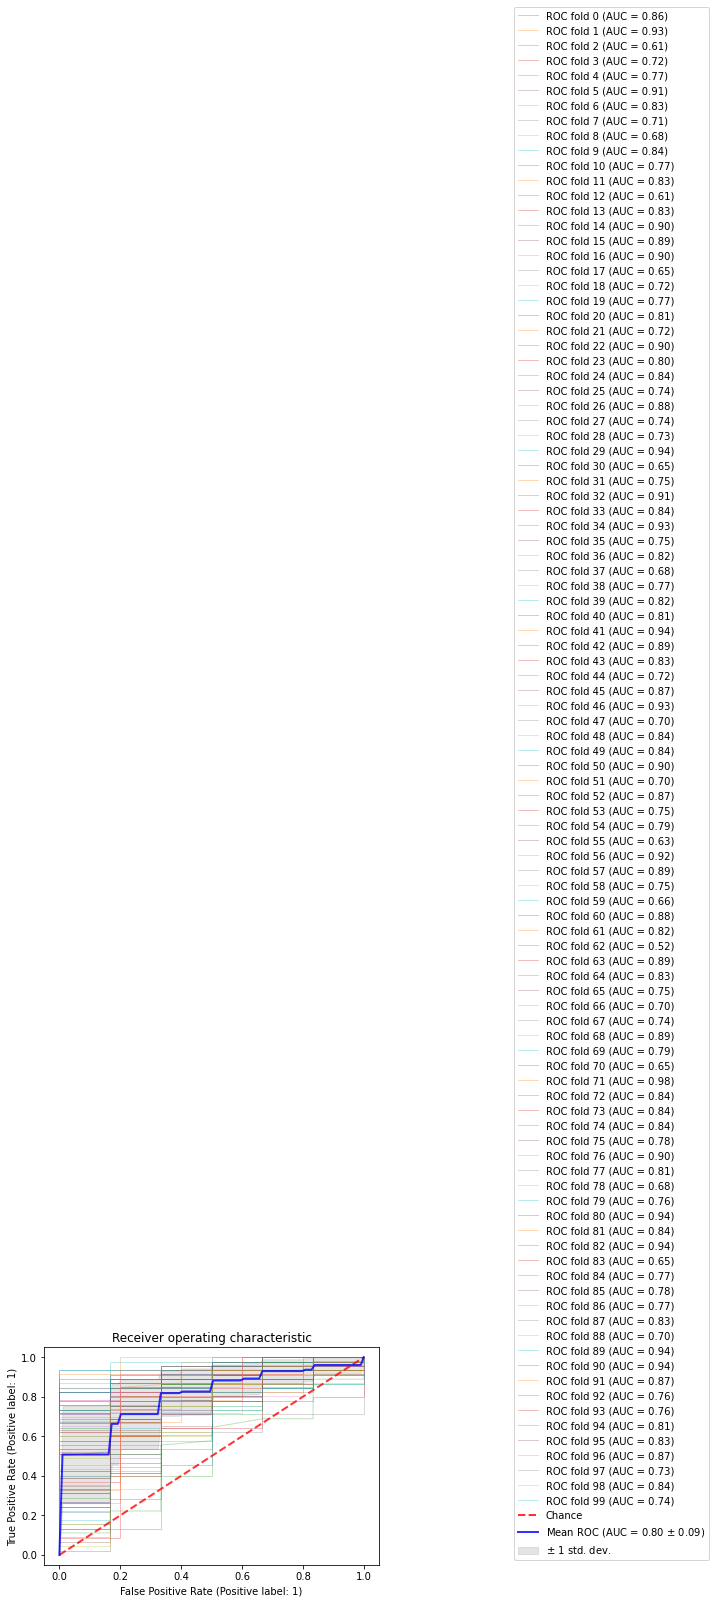

In [6]:
#02_model_evaluation.py
# This script evaluates the performance of an XGBoost classifier using Repeated Stratified K-Fold cross-validation.
# It plots the ROC curve for each fold and reports the mean ROC-AUC with standard deviation.
   
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Load dataset
dataset2 = pd.read_csv("C:/sat_cohort/final/SAT_Cohort_XAI_model2_QoL_bi_expActlong.csv", header=0)
X = dataset2.loc[:, 'age':'diffI_Reflecting']
y = dataset2['geh_less33_0']

#Define classifier with fixed parameters after parameter tuning

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=20)
classifier = XGBClassifier(
booster='gbtree',
    objective='binary:logistic',
    max_depth= 3,
   learning_rate= 0.06,
   n_estimators= 50,   
   gamma= 0.5, 
   min_child_weight= 2, 
   subsample= 0.89,
   use_label_encoder=False,
   eval_metric='logloss'
)


#Initialize storage

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#Create plot

fig, ax = plt.subplots()

#Perform cross-validation and plot ROC for each fold

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz =RocCurveDisplay.from_estimator(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)

# Interpolate true positive rates

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

#Plot chance line

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

#Plot mean ROC and confidence interval

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

#Calculate upper and lower bounds of TPR

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

#Shade confidence interval region
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

#Final plot settings

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right", bbox_to_anchor=(2,0) )
plt.show()


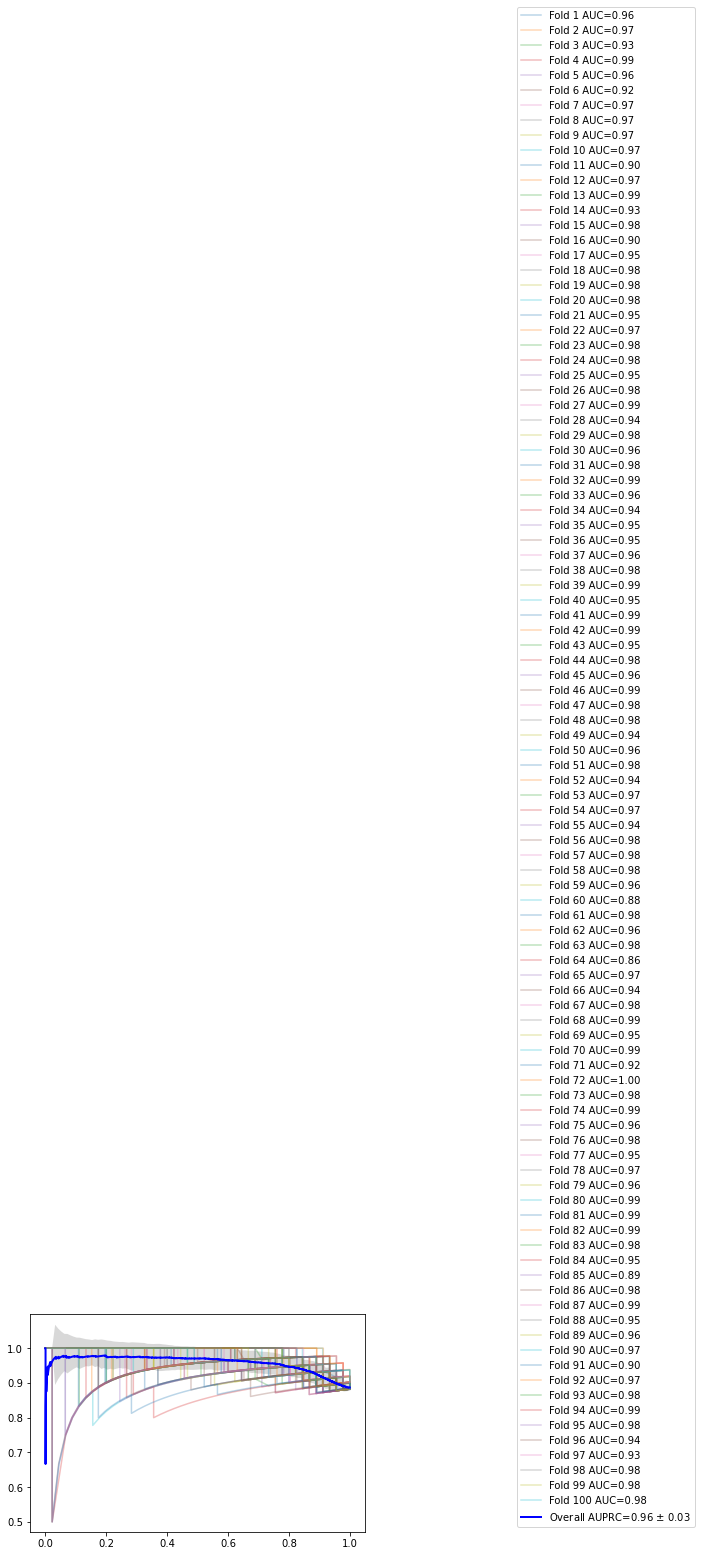

In [7]:
#03_prc_evaluation.py
# ==============================================================================
# 03_prc_evaluation.py
# ==============================================================================
# This script performs repeated stratified cross-validation to evaluate the 
# performance of an XGBoost classifier using Precision-Recall Curve (PRC) analysis.
# For each fold, the PRC is computed and interpolated onto a common recall grid.
# The mean PRC and the 95% confidence interval (±1 SD) are visualized.
# The final result includes fold-level AUPRC values and the overall aggregated AUPRC.
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
from xgboost import XGBClassifier

# ====================
# Prepare storage
# ====================
stats_prc = []
y_real = []
y_proba = []

precision_array = []
recall_array = np.linspace(0, 1, 100)

# ====================
# Run CV and compute PRC
# ====================

# Perform repeated stratified cross-validation to evaluate Precision-Recall Curve (PRC)
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    # Split into training and test sets for the current fold
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training fold
    classifier.fit(Xtrain, ytrain)
    
    # Predict probabilities for the test fold
    pred_proba = classifier.predict_proba(Xtest)
    
    # Compute precision-recall curve for this fold
    precision_fold, recall_fold, _ = precision_recall_curve(ytest, pred_proba[:, 1])
    
    # Reverse order to ensure ascending recall values for interpolation
    precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]
    
    # Interpolate precision values onto a fixed recall grid
    prec_array = np.interp(recall_array, recall_fold, precision_fold)
    
    # Calculate area under the PR curve (AUPRC) for this fold
    pr_auc = auc(recall_array, prec_array)
    
    # Store interpolated precision array for mean/SD calculation later
    precision_array.append(prec_array)
    
    # Label for the individual fold curve
    lab_fold = 'Fold %d AUC=%.2f' % (i + 1, pr_auc)
    
    # Plot the PR curve for this fold
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    
    # Store predictions and true labels for the full set
    y_real.append(ytest)
    y_proba.append(pred_proba[:, 1])
    
    # Store fold AUPRC
    stats_prc.append(pr_auc)

# ====================
# Aggregate and visualize mean PRC
# ====================

# Concatenate all predictions and labels from each fold
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)

# Compute the overall precision-recall curve across all folds
precision, recall, _ = precision_recall_curve(y_real, y_proba)

# Label with overall AUPRC and standard deviation
lab = 'Overall AUPRC=%.2f $\pm$ %0.2f' % (auc(recall, precision), np.std(stats_prc))

# Plot the aggregated PRC curve
plt.plot(recall, precision, lw=2, color='blue', label=lab)

# Display legend outside of the plot
plt.legend(loc='lower right', bbox_to_anchor=(2, 0))

# ====================
# Plot shaded region for ±1 std. dev.
# ====================

# Compute mean and standard deviation of interpolated precision arrays
mean_precision = np.mean(precision_array, axis=0)
std_precision = np.std(precision_array, axis=0)

# Fill area between mean ± std for visualizing variability
plt.fill_between(recall_array,
                 mean_precision + std_precision,
                 mean_precision - std_precision,
                 alpha=0.3, linewidth=0, color='grey')

# Show final PRC plot
plt.show()